<a href="https://colab.research.google.com/github/KazukiHirata-sun/ai_project_dev_2022/blob/main/section_2/Simple_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop simple project using BERT
Use the pre-trained model to solve fill-in-the-blank questions on the JLPT exam.

[Reference](https://viblo.asia/p/hieu-hon-ve-bert-buoc-nhay-lon-cua-google-eW65GANOZDO)

## Installation of transformers
BERT which is a model for [Natural Language Processing](https://www.techtarget.com/searchenterpriseai/definition/natural-language-processing-NLP) (NLP) is developed as Transformer-based model.
Creating a project using BERT also requires an understanding of [Transformers](https://viblo.asia/p/transformers-nguoi-may-bien-hinh-bien-doi-the-gioi-nlp-924lJPOXKPM).


In [ ]:
!pip install transformers
!pip install fugashi
!pip install ipadic

## Use of Japanese pre-training models
Transformers can use pre-training models for a variety of languages, including Japanese pre-training models provided by Tohoku University.
This time, we will use "[fugashi](https://github.com/polm/fugashi)," a wrapper library for [MeCab](https://viblo.asia/p/phan-tich-ngon-ngu-tieng-nhat-voi-phan-mem-mecab-va-gem-natto-7rVRqpB9v4bP), an open-source morphological analyzer.

Reference：https://huggingface.co/docs/transformers/model_doc/bert-japanese

In [28]:
from transformers import BertJapaneseTokenizer

model_name ='cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

### Try using Tokenizer in Japanese
Prepare a partially masked Japanese sentence and [tokenize](https://huggingface.co/docs/transformers/main_classes/tokenizer) it.

Each segmented word is called a "Token".

In [ ]:
text = '私は大学で[MASK]を勉強しています。'
tokens = tokenizer.tokenize(text)

print(tokens)

The tokens need to be converted from text to numerical values in order for the model to predict the part marked [MASK].

In [ ]:
input_ids = tokenizer.encode(text, return_tensors='pt')
input_ids = input_ids.cuda()

print(input_ids)

When the numeric tokens are converted to text, [CLS] and [SEP] are added.
These are special tokens that are added when tokenizer.encode is executed.
CLS is called a classification token and is used at the beginning of a sentence.
When performing sentiment analysis or other classification, the
The final output at the CLS position is treated as representative of the entire sentence.
SEP is used to distinguish sentences in tasks that use multiple sentences (e.g., a question sentence and a correct answer sentence), but here it has no particular meaning other than being attached to the end of the sentence.

Incidentally, compared to the numbers above, we can see that [MASK] is 4 if it is a number.

In [ ]:
#@title
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print(tokens)

### Try using Japanese BERT
Try solving fill-in-the-blank questions using a pre-trained model for Masked Language Modeling ( [MLM](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForMaskedLM): a language model for partially masked sentences).

In [ ]:
from transformers import BertForMaskedLM

bert_mlm = BertForMaskedLM.from_pretrained(model_name)
bert_mlm = bert_mlm.cuda()

In [ ]:
import torch

# Enter a numerical token in Bert to obtain a score.
with torch.no_grad():
  output = bert_mlm(input_ids=input_ids)
  scores = output.logits

#Find out where [MASK] is located ([MASK] is 4 if it is a numerical token.)
mask_position = input_ids[0].tolist().index(4)

# Extract the most likely token at the [MASK] position and convert
id_best = scores[0, mask_position].argmax(-1).item()
token_best = tokenizer.convert_ids_to_tokens(id_best)
text = text.replace('[MASK]',token_best)
print(text)

Take out the top 10 in order of highest score.

In [ ]:
top_mask = scores[0, mask_position].topk(10)
tokens = tokenizer.convert_ids_to_tokens(top_mask.indices)
print(tokens)

## Solve fill-in-the-blank questions on the JLPT exam
Answer the following questions from the [JLPT N1](https://www.jlpt.jp/samples/sample09.html) reading comprehension exam using BERT.

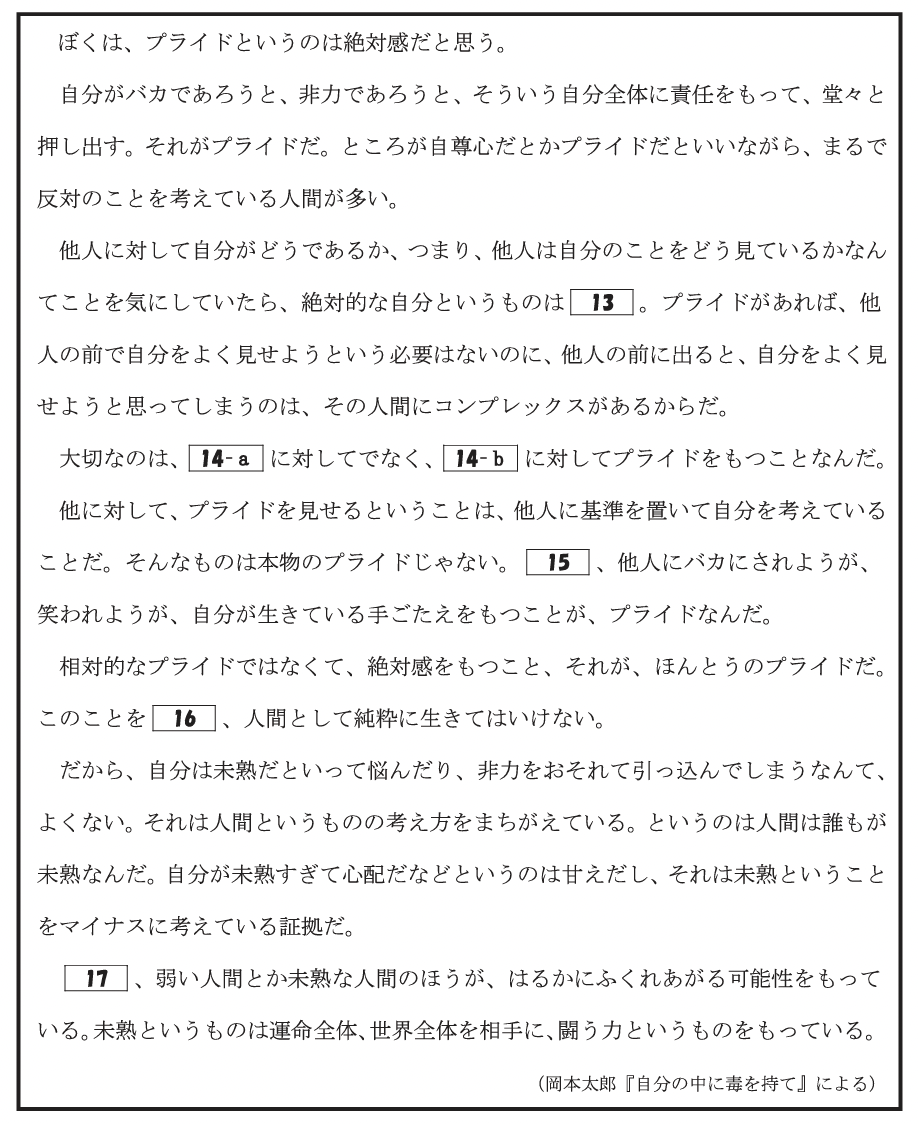

First, the process up to this point is converted to a function.

In [35]:
def mask_predict(text, tokenizer, bert_mlm):
  # Converted from text to numerical token and enter in BEBT to obtain a score.
  input_ids = tokenizer.encode(text, return_tensors='pt')
  input_ids = input_ids.cuda()
  with torch.no_grad():
    output = bert_mlm(input_ids=input_ids)
    scores = output.logits
  
  # Find out where [MASK] is located
  mask_position = input_ids[0].tolist().index(4)

  # Take out the top 10 in order of highest score.
  top_mask = scores[0, mask_position].topk(10)
  tokens = tokenizer.convert_ids_to_tokens(top_mask.indices)
  top_scores = top_mask.values.cpu().numpy()

  # Replace the 10 tokens with [MASK] and create a sentence
  top_text = []
  for token in tokens:
    token = token.replace('##', '')
    top_text.append(text.replace('[MASK]',token, 1))

  return top_text, top_scores

Try out the function we just created

In [ ]:
text = '私の夢は日本で[MASK]として働くことです。'
mask_predict(text=text, tokenizer=tokenizer, bert_mlm=bert_mlm)

Now we would like to have BERT solve a JTPT exam question using the function we just created.

We will use an algorithm called [Beam Search](https://www.width.ai/post/what-is-beam-search) to infer the words that will fit into multiple blanks.

Beam Search is a method of predicting each word by selecting n (or more than one) candidate words in order of increasing score.

In [37]:
import numpy as np

def beam_search(text, tokenizer, bert_mlm):
  top_text = [text]
  top_scores = np.array([0])
  for _ in range(text.count('[MASK]')):
    text_candidates = []
    score_candidates = []
    for text_mask , score in zip(top_text, top_scores):
      top_text_inner, top_scores_inner = mask_predict(text_mask, tokenizer, bert_mlm)
      text_candidates.extend(top_text_inner)
      score_candidates.append(score + top_scores_inner)

    # Select the sentence with the highest total score from the filled-in sentences.
    score_candidates = np.hstack(score_candidates)
    idx_list = score_candidates.argsort()[::-1][:5]
    top_text = [text_candidates[idx] for idx in idx_list]
    top_scores = score_candidates[idx_list]
  
  return top_text

In [ ]:
text = '私の夢は日本で[MASK]として働くことです。そのために毎日[MASK]を勉強しています。今はアプリ開発に興味があるので[MASK]の練習をしています。'
beam_search(text=text, tokenizer=tokenizer, bert_mlm=bert_mlm)

Finally, let's try to solve the JLPT N1 questions.

In [ ]:
text = '他人に対して自分がどうであるか、つまり、他人は自分のことをどう見ているかなんてことを気にしていたら、絶対的な自分というものは[MASK]。プライドがあれば、他人の前で自分をよく見せようと言う必要はないのに、他人の前に出ると、自分をよく見せようと思ってしまうのは、その人間にコンプレックスがあるからだ。大切なのは、[MASK]に対してではなく、[MASK]に対してプライドをもつことなんだ。他に対して、プライドを見せるということは、他人に基準を置いて自分を考えていることだ。そんなものは本物のプライドじゃない。[MASK]、他人にバカにされようが、笑われようが、自分が生きている手ごたえをもつことが、プライドなんだ。'
beam_search(text=text, tokenizer=tokenizer, bert_mlm=bert_mlm)